In [1]:
import boto3
from tqdm import tqdm
import json
import os
import xmltodict
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import multiprocessing
import matplotlib.pyplot as plt
import time

In [2]:
input_bucket_name = 'training-data-alkymi'
validation_folder = f'pageseg/5/validation'
annotation_folder = f'pageseg/5/validation_annotation'

output_bucket = 'batch-transform-results'
# batch_job_name = "notebook-batch-transform/" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
batch_job_name = 'notebook-batch-transform2019-07-20-18-27-13'
output_location = f's3://{output_bucket}/{batch_job_name}/'

In [3]:
s3 = boto3.client('s3')

def get_all_s3_keys(s3_path):
    """
    Get a list of all keys in an S3 bucket.

    :param s3_path: Path of S3 dir.
    """
    keys = []

    if not s3_path.startswith('s3://'):
        s3_path = 's3://' + s3_path

    bucket = s3_path.split('//')[1].split('/')[0]
    prefix = '/'.join(s3_path.split('//')[1].split('/')[1:])
    kwargs = {'Bucket': bucket, 'Prefix': prefix}
    print(kwargs)
    while True:
        resp = s3.list_objects_v2(**kwargs)
        for obj in resp['Contents']:
            keys.append(obj['Key'])

        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break

    return keys

In [4]:
object_keys = get_all_s3_keys(output_location)
print(len(object_keys))

{'Bucket': 'batch-transform-results', 'Prefix': 'notebook-batch-transform2019-07-20-18-27-13/'}
7758


In [5]:
results = []

labels = ['text', 'graphical_chart', 'structured_data']
gt_counts = dict()

for object_key in tqdm(object_keys):
    hash_key, page_num = object_key.split('/')[1].split('.')[0].split('_')
    pred_obj = s3.get_object(Bucket=output_bucket, Key=object_key)
    pred = json.loads(pred_obj['Body'].read())['pred']
    
    xml_key = f'{annotation_folder}/{hash_key}_{page_num}.xml'
    xml_obj = s3.get_object(Bucket=input_bucket_name, Key=xml_key)
    xml_data = xmltodict.parse(xml_obj['Body'].read(), force_list={'object'})
    
    img_key = f'{validation_folder}/{hash_key}_{page_num}.png'
    img_obj = s3.get_object(Bucket=input_bucket_name, Key=img_key)
    img_data = BytesIO(img_obj['Body'].read())
    img = Image.open(img_data)
    
    for label in labels:
        for obj in xml_data['annotation']['object']:
            if obj['name'] == label:
                gt_counts[label] = gt_counts.get(label, 0) + 1
                
        for pred_box in pred.get(label, []):
            pred_mask = np.zeros(img.size)
            pred_mask[int(pred_box[0]):int(pred_box[2]), int(pred_box[1]):int(pred_box[3])] = 1
            iou_max = 0
            result = None
            for obj in xml_data['annotation']['object']:
                if obj['name'] == label:
                    gt_box = obj['bndbox']
                    gt_mask = np.zeros(img.size)
                    gt_mask[int(float(gt_box['xmin'])):int(float(gt_box['xmax'])), 
                            int(float(gt_box['ymin'])):int(float(gt_box['ymax']))] = 1
                    
                    intersection = np.logical_and(gt_mask, pred_mask).sum()
                    union = np.logical_or(gt_mask, pred_mask).sum()
                    iou = intersection/union if union else 0.0
                    if iou > iou_max:
                        iou_max = iou
                result = (pred_box[4], iou_max, label)
            results.append(result)

100%|██████████| 7758/7758 [1:31:01<00:00,  1.74it/s]  


In [6]:
gt_counts

{'text': 57764, 'graphical_chart': 2243, 'structured_data': 12227}

In [10]:
iou_threshes = np.arange(0.5, 1.0, 0.05)
aps = []
label = 'text'
for iou_thresh in iou_threshes:
    results_df = pd.DataFrame(results, columns=['confidence', 'max_iou', 'label'])
    results_df = results_df.sort_values('confidence', ascending=False)
    
    
    results_df = results_df[results_df.label == label]
#     results_df = results_df[results_df.confidence > .5]
    results_df = results_df.reset_index(drop=True)
    results_df['cum_sum'] = (results_df.max_iou > iou_thresh).cumsum()
    results_df['precision'] = results_df.apply(lambda row: row.cum_sum/(row.name+1), axis=1)
    results_df['recall'] = results_df.cum_sum/gt_counts[label]

    precisions = [1.0]
    for rec in np.arange(.1, 1.1, .1):
        p = results_df.precision[results_df.recall>=rec].head(1)
        precisions.append(float(p) if len(p) else 0.0)
    ap = sum(precisions)/11
    aps.append(ap)

In [11]:
sum(aps)/len(aps)

0.3695818230136436

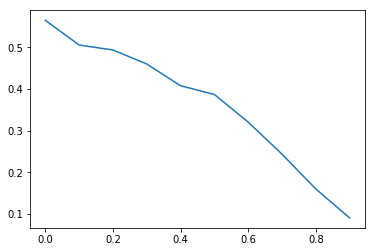

In [28]:
plt.plot(np.arange(0,1,.1),aps)

Text(0, 0.5, 'Precision')

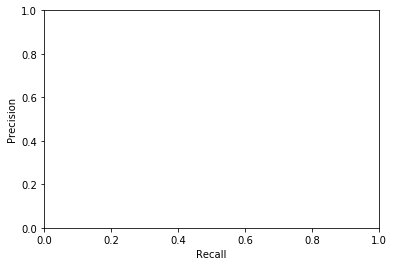

In [8]:
plt.plot(results_df.recall, results_df.precision)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')

In [25]:
results_df = pd.DataFrame(results, columns=['confidence', 'max_iou', 'label'])
results_df = results_df.sort_values('confidence', ascending=False)
sum(results_df.label=='text')

379

In [32]:
results_df

,confidence,max_iou,label,cum_sum,precision,recall
0,0.621753,0.000000,text,0,0.0,0.0
1,0.484835,0.000000,text,0,0.0,0.0
2,0.363818,0.000000,text,0,0.0,0.0
3,0.354376,0.000000,text,0,0.0,0.0
4,0.354322,0.000000,text,0,0.0,0.0
5,0.350049,0.000000,text,0,0.0,0.0
6,0.346114,0.154426,text,0,0.0,0.0
7,0.332541,0.109862,text,0,0.0,0.0
8,0.295979,0.007139,text,0,0.0,0.0
9,0.289170,0.156540,text,0,0.0,0.0


In [35]:
set(results_df.precision)

{0.0}

In [5]:
import numpy as np
np.exp(-10)

4.5399929762484854e-05